In [1]:
import json
from matplotlib import pyplot as plt
import numpy as np
import open3d as o3d
from src.EmbryoAlignment import Embryo
import seaborn as sns
from itertools import combinations
from sklearn.decomposition import PCA
from scipy.stats import median_abs_deviation
from scipy.spatial import KDTree, ConvexHull, Delaunay
from scipy.spatial.distance import pdist, squareform
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

with open('data/corresptissues.json') as f:
    corres_tissues = json.load(f)
    corres_tissues = {eval(k): v for k, v in corres_tissues.items()}
with open('data/tissuescolor.json') as f:
    colors_paper = json.load(f)
    colors_paper = {eval(k): v for k, v in colors_paper.items()}
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2021-11-26 14:31:19,425 - utils - Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - 2021-11-26 14:31:19,426 - utils - NumExpr defaulting to 8 threads.


# Setting up parameters

In [2]:
# Path to the input data
data_path = '../SpatialSC/Data/E8.5.h5ad'
# Path to the output folder
output_folder = 'out/'

# Set of genes that will be interpolated
genes_of_interest = ['Cck', 'Cnn1', 'Hbb-bh1', 'Nppa', 'Nppb', 'Tdgf1', 'Thbs4', 'Tnni3']

# List of tissues that are ignored to do coverslip registration
tissues_to_ignore = [13, 15, 16, 22, 27, 29, 32, 36, 40, 41]

# Coverslips to ignore
# on the starting side
nb_CS_begin_ignore = 0
# on the ending side
nb_CS_end_ignore = 2

# Gives more weight to some tissues to help the alignment
tissue_weight = {21:1000, 18:1}
# xy resolution
xy_resolution = .6
# Distance max that two beads can be linked together between coverslips
th_d = 150
# Threshold bellow which the beads will be considered noise.
# Value between 0 (all beads taken) and 1 (almost no beads taken)
outlier_threshold = .1

# Number of interpolated layers between two consecutive coverslips
nb_interp = 5

# Loading the embryo

In [3]:
embryo = Embryo(data_path, tissues_to_ignore, corres_tissues, tissue_weight=tissue_weight,
                xy_resolution=xy_resolution, genes_of_interest=genes_of_interest,
                nb_CS_begin_ignore=nb_CS_begin_ignore, nb_CS_end_ignore=nb_CS_end_ignore,
                store_anndata=True)
embryo.removing_spatial_outliers(th=outlier_threshold)
embryo.reconstruct_intermediate(embryo, th_d=th_d, genes=genes_of_interest)

In [4]:
tissues_to_process = [5, 10, 12, 18, 21, 24, 30, 31, 33, 34, 39]
th_vol = .025
_ = embryo.get_3D_differential_expression(tissues_to_process, th_vol);

/home/guignard/workspace/scSpatial/src/EmbryoAlignment.py:938: RuntimeWarning: invalid value encountered in true_divide
  mean1 = np.cumsum(hist * bin_centers) / weight1
/home/guignard/workspace/scSpatial/src/EmbryoAlignment.py:939: RuntimeWarning: invalid value encountered in true_divide
  mean2 = (np.cumsum((hist * bin_centers)[::-1]) / weight2[::-1])[::-1]
/home/guignard/miniconda3/envs/SpatialSCII/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/guignard/miniconda3/envs/SpatialSCII/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [30]:
def plot_top_3D_diff_expr_genes(self, tissues_to_process, nb_genes=20,
                               repetition_allowed=False, compute_z_score=True,
                               fig=None, ax=None):
    from collections import Counter
    tmp_T = set(tissues_to_process).difference(self.tissues_diff_expre_processed)
    if len(tmp_T) != 0:
        print("You asked to plot tissues that were not already processed")
        print("The following tissues will be ignored:")
        for t in tmp_T:
            print(f"\t - {t}")
    tissues_to_process = list(set(tissues_to_process).intersection(self.tissues_diff_expre_processed))
    genes_of_interest = []
    gene_dict = {}
    tissue_genes = {}
    genes_in = {}
    added_genes = 0 if repetition_allowed else 4
    for t in tissues_to_process:
        data_t = self.diff_expressed_3D[t]
        G_N = data_t['Interesting genes'][np.argsort(data_t['Distance_to_reg'])[:-nb_genes*added_genes-1:-1]]
        G_V = np.sort(data_t['Distance_to_reg'])[:-nb_genes*added_genes-1:-1]
        genes_of_interest.extend(G_N[:nb_genes])
        for g, v in zip(G_N, G_V):
            tissue_genes.setdefault(g, []).append(t)
            gene_dict[(t, g)] = v
        genes_in[t] = list(G_N)

    if not repetition_allowed:
        dict_counter = Counter(genes_of_interest)
        acc = 0
        while any([1<k for k in dict_counter.values()]):
            t = tissues_to_process[acc%len(tissues_to_process)]
            for g in genes_in[t]:
                if 1<dict_counter[g]:
                    tissues = np.array(tissue_genes[g])
                    values = [gene_dict[(t, g)] for t in tissues]
                    if tissues[np.argsort(values)][-1]!=t:
                        genes_in[t].remove(g)
            genes_of_interest = []
            for t in tissues_to_process:
                genes_of_interest.extend(genes_in[t][:nb_genes])
            dict_counter = Counter(genes_of_interest)
            acc += 1
    values = np.zeros((nb_genes*len(tissues_to_process), len(tissues_to_process)))
    tissue_order = []
    for i, g in enumerate(genes_of_interest):
        for j, t in enumerate(tissues_to_process):
            data_t = self.diff_expressed_3D[t]
            if g in data_t['Interesting genes']:
                values[i, j] = data_t['Distance_to_reg'][np.where(data_t['Interesting genes']==g)][0]
            if i==0:
                tissue_order.append(t)
    # z_score = (values - np.mean(values, axis=1).reshape(-1, 1))/np.std(values, axis=1).reshape(-1, 1)
    if compute_z_score:
        z_score = stats.zscore(values, axis=0)
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,max(5, round(1.5*nb_genes))))
    if fig is None:
        fig = ax.get_figure()
    ax.imshow(z_score, interpolation='nearest', cmap='Reds')
    ax.set_xticks(range(len(tissue_order)))
    ax.set_xticklabels([self.corres_tissue[t] for t in tissue_order], rotation=90)
    ax.set_yticks(range(values.shape[0]))
    ax.set_yticklabels(list(self.anndata[:,genes_of_interest].var_names))
    fig.tight_layout()
    return fig, ax

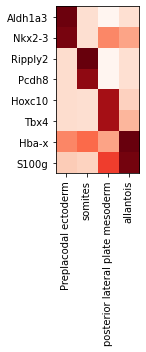

In [32]:
# embryo.plot_top_interesting_genes(tissues_to_process[:2], nb_genes=1)
from scipy import stats
plot_top_3D_diff_expr_genes(embryo, tissues_to_process[:4], nb_genes=2);

# Definition of some functions

In [ ]:
def build_gabriel_graph(self, node_ids, pos):
    tmp = Delaunay(pos)
    delaunay_graph = {}

    for N in tmp.simplices:
        for e1, e2 in combinations(np.sort(N), 2):
            delaunay_graph.setdefault(e1, set()).add(e2)
            delaunay_graph.setdefault(e2, set()).add(e1)
    Gabriel_graph = {}

    for e1, neighbs in delaunay_graph.items():
        for ni in neighbs:
            if not any([np.linalg.norm((pos[ni] + pos[e1])/2 - pos[i])<np.linalg.norm(pos[ni] - pos[e1])/2
                    for i in delaunay_graph[e1].intersection(delaunay_graph[ni])]):
                Gabriel_graph.setdefault(e1, set()).add(ni)
                Gabriel_graph.setdefault(ni, set()).add(e1)

    final_GG = {}
    for e1, neighbs in Gabriel_graph.items():
        neighbs = np.array(list(neighbs))
        distances = np.linalg.norm(pos[e1] - [pos[ni] for ni in neighbs], axis=1)
        final_GG[node_ids[e1]] = set([node_ids[ni] for ni in neighbs[distances<=5*np.median(distances)]])
    return final_GG

def threshold_otsu(values, nbins=256):
    """Return threshold value based on Otsu's method.
        Parameters
        ----------
        image : array
        Input image.
        nbins : int
        Number of bins used to calculate histogram. This value is ignored for
        integer arrays.
        Returns
        -------
        threshold : float
        Threshold value.
        References
        ----------
        .. [1] Wikipedia, http://en.wikipedia.org/wiki/Otsu's_Method
    """
    map(np.histogram, values)
    hist, bin_edges = np.histogram(values, nbins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
    
    hist = hist.astype(float)

    # class probabilities for all possible thresholds
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]
    # class means for all possible thresholds
    mean1 = np.cumsum(hist * bin_centers) / weight1
    mean2 = (np.cumsum((hist * bin_centers)[::-1]) / weight2[::-1])[::-1]

    # Clip ends to align class 1 and class 2 variables:
    # The last value of `weight1`/`mean1` should pair with zero values in
    # `weight2`/`mean2`, which do not exist.
    variance12 = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

    idx = np.argmax(variance12)
    threshold = bin_centers[:-1][idx]
    return threshold

def compute_vol_metrics(gene, percentile=5):
    positive_cells = np.where(th[gene]<sub_data[:,gene])[0]
    positive_cells = cells[positive_cells]
    positive_cells_set = set(list(positive_cells))
    nb_neighbs = []
    for p in positive_cells:
        nb_neighbs.append(len([n for n in GG[p] if n in positive_cells]))
    avg_nb_neighbs = np.mean(nb_neighbs)
    
    positive_positions = [list(embryo.final[c])+[embryo.z_pos[c]] for c in positive_cells]
    distances = pdist(positive_positions)
    D_mat = squareform(distances)
    D_mat[D_mat==0] = np.nan
    
    closest = np.percentile(np.nanmin(D_mat, axis=0), percentile)
    diameter = np.percentile(np.nanmax(D_mat, axis=0), 100-percentile)
    med_min = np.median(np.nanmin(D_mat, axis=0))
    med_max = np.median(np.nanmax(D_mat, axis=0))
    med_dist = np.median(distances)
    ch = ConvexHull(positive_positions)
    solidity = len(positive_positions)*bead_size/ch.volume
    return (avg_nb_neighbs, closest,
            diameter, med_min, med_max,
            med_dist, solidity)

# Building of the gabriel graph necessary to compute the neighborhood

In [ ]:
cells = list(embryo.all_cells)
pos_3D = [np.array(list(embryo.final[c])+[embryo.z_pos[c]]) for c in cells]

GG = build_gabriel_graph(embryo, cells, pos_3D)

### __All the cells above need to be ran only once per embryo loading. You need to rerun them only if you rerun the embryo (to change the genes to generate for example)__

# Defining the tissue and some parameters

In [ ]:
# Tissue
t = 21

# Looking for positions of low expression
invert = False

# Volume threshold below which genes are ignored
th_vol = 0.8*1e6

# Bead size (Might be wrong now but does not change the resulting genes)
bead_size = (10*10*30)

# Values against which the linear regression is done
# It is important that the relationship between x and y is linear!!!
# NOTE: For commodity; this value is redefined later
regression_x = 'avg_nb_neighbs'
regression_y = 'volume'

# Distance to the regression line above which a gene is considered an outlier
# (the higher the value is the more stringent the classifier is)
# NOTE: For commodity; this value is redefined later
th_pos = 7*1e6

# Preparing the data

In [ ]:
# Copying the data to make sure not to alter the original
data = embryo.anndata.copy().X
if invert:
    data = np.max(data) - data

# Computing the threshold value above which a cell is considered positive for a given gene expression value
# A unique threshold is computed for each gene assuming that within the embryo there are cells that express
# and cells that do not express (meaning that the threshold splits the distribution in two classes)
out = map(threshold_otsu, data.T)
th = []
for o in out:
    th += [o]
th = np.array(th)

# Cells from tissue *t*
cells = np.array([c for c in embryo.all_cells if embryo.tissue[c]==t])

# Splicing the array to only have tissue *t* cells
sub_data = data[cells]

# Total volume of the tissue (ie nb beads * bead size)
volume_total = len(cells) * bead_size

# Total volume of expressing cells
sub_volumes = np.sum(th<sub_data, axis=0) * bead_size

# Genes that have an expressing volume of at least th_vol
interesting_genes = np.where(th_vol<sub_volumes)[0]

# Computing the spatial metrics

In [ ]:
# Compute spatial metrics for the set of interesting genes
from multiprocessing import Pool
with Pool() as pool:
    out = pool.map(compute_vol_metrics, interesting_genes)
(avg_nb_neighbs, closest,
 diameter, med_min, med_max,
 med_dist, solidity) = [], [], [], [], [], [], []
for (av_n, close, dia, m_min, m_max, m_dist, soli) in out:
    avg_nb_neighbs.append(av_n)
    closest.append(close)
    diameter.append(dia)
    med_min.append(m_min)
    med_max.append(m_max)
    med_dist.append(m_dist)
    solidity.append(soli)
    
# Build a dataframe with the previously computed metrics
data_plot = {
    'volume log': np.log(sub_volumes[th_vol<sub_volumes]),
    'volume': sub_volumes[th_vol<sub_volumes],
    'volume ratio': sub_volumes[th_vol<sub_volumes]/volume_total,
    'avg_nb_neighbs': np.array(avg_nb_neighbs),
    'closest': np.array(closest),
    'diameter': np.array(diameter),
    'med_min': np.array(med_min),
    'med_max': np.array(med_max),
    'med_dist': np.array(med_dist),
    'solidity': np.array(solidity)
}

# Computing the linear regression to find the regionalized genes

In [ ]:
# Compute the linear regression
# Distance to the regression line above which a gene is considered an outlier
# (the higher the value is the more stringent the classifier is)
# It might be interesting to play with this value.
th_pos = 8*1e5

# Value against which the linear regression is done
# It is important that the relationship between x and y is linear!!!
regression_x = 'avg_nb_neighbs'
regression_y = 'volume'

regr = linear_model.LinearRegression()
data_x_reshaped = data_plot[regression_x].reshape(-1,1)
data_y_reshaped = data_plot[regression_y].reshape(-1,1)
regr.fit(data_x_reshaped, data_y_reshaped)
b = regr.intercept_[0]
a = regr.coef_[0][0]
line = lambda x: (a*np.array(x)+b)
X = np.linspace(np.min(data_plot[regression_x]), np.max(data_plot[regression_x]), 100)

data_plot['Distance_to_reg'] = np.abs((data_y_reshaped-regr.predict(data_x_reshaped))[:,0])
data_plot['Outlier\n(nb neighbs)'] = th_pos<data_plot['Distance_to_reg']

# Plotting the results

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
x = 'avg_nb_neighbs'
y = 'volume'
print_text = True
sns.scatterplot(data=data_plot, x=x, y=y, ax=ax, hue='Outlier\n(nb neighbs)')
if x==regression_x:
    ax.plot(X, line(X), '-')
not_to_take = lambda c: embryo.final[c][0]<0
found_g = set(embryo.anndata[:,interesting_genes[data_plot['Outlier\n(nb neighbs)']]].var_names)
print(found_g)

if print_text:
    for i, gene in enumerate(np.where(data_plot['Outlier\n(nb neighbs)'])[0]):
        txt = embryo.anndata[:,interesting_genes[gene]].var_names[0]
        plt.text(x=data_plot[x][gene]+.01,y=data_plot[y][gene],s=txt, 
                 fontdict=dict(color='red',size=8), va='baseline')
        
fig.tight_layout()
fig.savefig(f'{x}_{y}_{corres_tissues[t]}.pdf')

In [ ]:
sorted(found_g)